In [78]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis

In [79]:
%run optimization_criterions.ipynb

In [80]:
timezone = pytz.timezone("Europe/Paris")
time_from = datetime.datetime(2000, 1, 1, tzinfo = timezone)
time_to = datetime.datetime.now(timezone) + datetime.timedelta(days=1)
if mt5.initialize():
    # Obtener portfolio
    symbols = mt5.symbols_get()
    list_tickers = [symbol.name for symbol in symbols if "ETF" in symbol.path]
    database = [mt5.copy_rates_range(ticker, mt5.TIMEFRAME_D1, time_from, time_to) for ticker in list_tickers]
    df_portfolio = pd.DataFrame()
    for ticker, data in zip(list_tickers, database):
        temp_df = pd.DataFrame(data['close'], index=data['time'], columns=[ticker])
        df_portfolio = pd.concat([df_portfolio, temp_df], axis=1)
    df_portfolio.index.names = ['time']
    df_portfolio.index = pd.to_datetime(df_portfolio.index, unit='s')
    df_portfolio = df_portfolio.dropna().pct_change().dropna()
    # Obtener índice de referencia
    data_index = mt5.copy_rates_range('SP500', mt5.TIMEFRAME_D1, time_from, time_to)
    df_index = pd.DataFrame(data_index['close'], index=data_index['time'], columns=['index'])
    df_index = df_index.dropna().pct_change().dropna()
    df_index.index.names = ['time']
    df_index.index = pd.to_datetime(df_index.index, unit='s')


In [81]:
# Distancia intercuartílica
Q1 = df_portfolio.quantile(0.25)
Q3 = df_portfolio.quantile(0.75)
IQR = Q3 - Q1
# Límites atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Datos atípicos
outliers = (df_portfolio < lower_bound) | (df_portfolio > upper_bound)
# Sustituye los valores atípicos por 0
df_portfolio = df_portfolio.mask(outliers, 0)

In [82]:
# Encontrar el número de activos
n = df_portfolio.shape[1]
# Inicialización de los pesos
x0=np.ones(n)
# Restricciones del problema de optimización
cons = [{'type': 'eq',
         'fun': lambda x: sum(abs(x))-1}]
# Establecer los límites
Bounds = [(0, 1) for i in range(0, n)]
# Resolución de los problemas de optimización
res_MV = minimize(SR_criterion, x0, 
                  method = 'SLSQP',
                  args=(df_portfolio),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
X_MV = res_MV.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.14372076471016795
            Iterations: 16
            Function evaluations: 1617
            Gradient evaluations: 16


<Axes: >

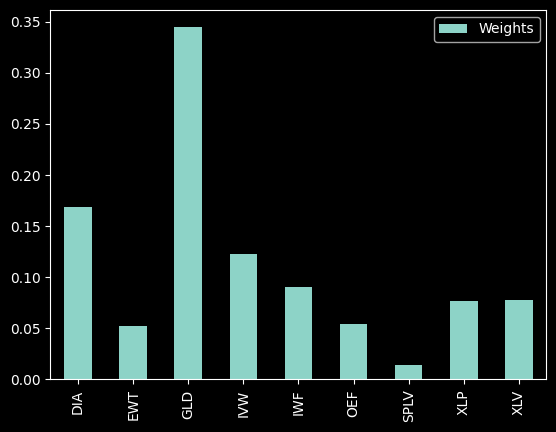

In [83]:
# De los activos seleccionados, selecciono los que más pesos tengan en la cartera
df_weights = pd.DataFrame(X_MV, index=list_tickers, columns=['Weights'])
df_weights = df_weights.loc[df_weights["Weights"] > np.mean(df_weights["Weights"].values)]
df_weights.plot(kind='bar')

<Axes: >

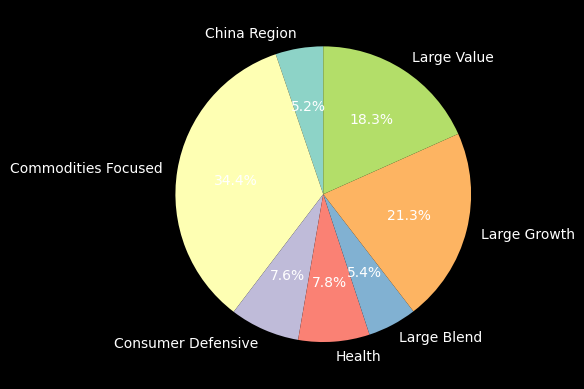

In [93]:
# Visualización de la distribución sectorial
tickers = yf.Tickers(df_weights.index.to_list())
tickers_type = dict()
for key, value in tickers.tickers.items():
    tickers_type[key] = value.info['category']
tickers_category = pd.DataFrame.from_dict(tickers_type, orient='index', columns=['category'])
df_category_weight = pd.concat([tickers_category, df_weights], axis=1)
df_category_weight.groupby('category').sum()['Weights'].plot(kind='pie', 
                                                             autopct='%1.1f%%', 
                                                             startangle=90, 
                                                             ylabel='')

<Axes: title={'center': 'Beta: 0.26 | Alpha: 0.16'}, xlabel='time'>

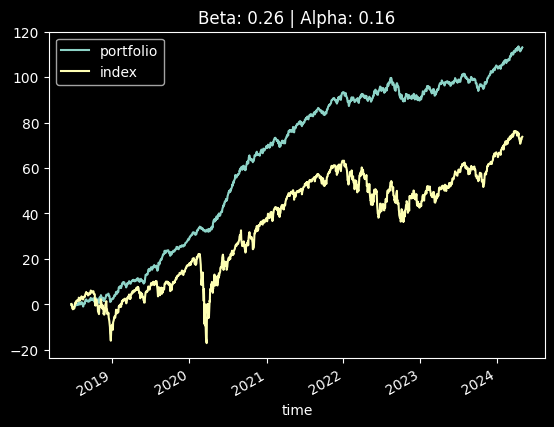

In [85]:
# Se calcula la rentabilidad de la cartera según el peso de cada activo
df_port = (pd.DataFrame(
    np.sum(
        np.multiply(
            df_portfolio[df_weights.index.to_list()].values,
            np.transpose(df_weights['Weights'].values)), 
        axis=1),
    index=df_portfolio.index,
    columns=['portfolio'])
)
df_index = df_index.loc[df_port.index[0]:df_port.index[-1]]
# Cálculo de los valores CAMP de la cartera
beta = beta_function(df_port, df_index)
alpha = alpha_function(df_port, df_index)
# Visualización del rendimiento
df_port_index = pd.concat([df_port, df_index], axis=1).cumsum(axis=0).multiply(100., axis=0).dropna()
df_port_index.plot(title=f"Beta: {beta:.2f} | Alpha: {alpha:.2f}")